In [1]:
import os 
import numpy as np
import pandas as pd
import scipy
import sklearn.metrics as skmetrics

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import lightning as L

import torchmetrics
from torchmetrics.regression import PearsonCorrCoef

## Dataloading

We are using the Megascale dataset. The train, validation and test sets are already predefined.
We provide code to load the data and helper functions to encode the sequences to numerical vectors (one-hot encoding). You can use this code as a starting point, adjust it, or use your own data loading. 

Each sequence will be treated as one batch (easier to deal with different leghts this way). The class below returns a dictionary containing the one-hot encoded sequence of dimension $Lx20$, the target sequence of dimension $Lx20$, containing the $\Delta \Delta G $ values, and a mask of the same dimension which indicates with a 1 if an experimental value is available for that position. Only compute your loss on the positions where an experimental value is available. So compute your loss similar to this example:

``` 
prediction = model(x)
loss = loss(prediction[mask==1],labels[mask==1])
```

### Megascale

In [12]:
aa_alphabet = 'ACDEFGHIKLMNPQRSTVWY' # amino acid alphabet
aa_to_int = {aa: i for i, aa in enumerate(aa_alphabet)} # mapping from amino acid to number

# function to one hot encode sequence
def one_hot_encode(sequence):
    # initialize a zero matrix of shape (len(sequence), len(amino_acids))
    one_hot = torch.zeros(len(sequence), len(aa_alphabet))
    for i, aa in enumerate(sequence):
        # set the column corresponding to the amino acid to 1
        one_hot[i].scatter_(0, torch.tensor([aa_to_int[aa]]), 1)
    return one_hot


# sequence data, comes already batched, so treat accordingly in dataloader (batch_size=1)
class SequenceData(Dataset):
    def __init__(self, csv_file, label_col="ddG_ML", normalize=True):
        """
        Initializes the dataset. 
        input:
            csv_file: path to the relevant data file, eg. "/home/data/mega_train.csv"
        """
        self.df = pd.read_csv(csv_file, sep=",")
        self.label_col = label_col
        # only have mutation rows
        self.df = self.df[self.df.mut_type!="wt"]
        # process the mutation row
        self.df["mutation_pos"] = self.df["mut_type"].apply(lambda x: int(x[1:-1])-1) # make position start at zero
        self.df["mutation_to"] = self.df["mut_type"].apply(lambda x: aa_to_int[x[-1]]) # give numerical label to mutation

        if normalize:
            # normalize between -1 and 1
            min_val = self.df[label_col].min()
            max_val = self.df[label_col].max()
            self.df[label_col] = self.df[label_col].apply(lambda x: 2 * (x - min_val) / (max_val - min_val) - 1)

        # group by wild type
        self.df = self.df.groupby("WT_name").agg(list)
        # get wild type names
        self.wt_names = self.df.index.values
        # precompute one-hot encoding for faster training
        self.encoded_seqs = {}
        for wt_name in self.wt_names:
            # get the correct row
            mut_row = self.df.loc[wt_name]
            seq = mut_row["wt_seq"][0]
            self.encoded_seqs[wt_name] = one_hot_encode(seq)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get the wild type name
        wt_name = self.wt_names[idx]
        # get the correct row
        mut_row = self.df.loc[wt_name]
        # get the wt sequence in one hot encoding
        sequence_encoding = self.encoded_seqs[wt_name]

        # create mask and target tensors
        mask = torch.zeros((1, len(sequence_encoding),20)) # will be 1 where we have a measurement
        target = torch.zeros((1, len(sequence_encoding),20)) # ddg values
        # all mutations from df
        positions = torch.tensor(mut_row["mutation_pos"])
        amino_acids = torch.tensor(mut_row["mutation_to"])
        # get the labels
        labels = torch.tensor(mut_row[self.label_col])

        for i in range(len(sequence_encoding)):
            mask[0,i,amino_acids[positions==i]] = 1 # one where we have data
            target[0,i,amino_acids[positions==i]] = labels[positions==i] # fill with ddG values
        
        # returns encoded sequence, mask and target sequence 
        return {"sequence": sequence_encoding[None,:,:].float(), "mask": mask, "labels": target}

In [13]:
# usage
dataset_train = SequenceData('data/mega_train.csv')
dataset_val= SequenceData('data/mega_val.csv')
dataset_test = SequenceData('data/mega_test.csv')

# use batch_size=1 bc we treat each sequence as one batch
dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=False)
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

### Domainome

In [38]:
filePath = "data/Supplementary_Table_2_fitness_scores_normalized.txt"
data = pd.read_csv(filePath, sep="\t")

In [4]:
# preprocess data
# first add a row with wt_seq, wt_name and mut_type columns and position starting with zero
# group by domain_ID, get first row, get sequence, change the * in the sequence to the wt_aa
# group  df by domain_ID
df = data.groupby("domain_ID")

# for each group get minimum position
df_min = df["position"].min()
# subtract this from data 
data["position_abs"] = data.apply(lambda x: x["position"] - df_min[x["domain_ID"]], axis=1)

# for each group get first row and get the sequence
df_first = df.first()

def replace_star(row):
    seq = row["aa_seq"]
    wt_aa = row["wt_aa"]
    return seq.replace("*", wt_aa)

df_first['aa_seq'] = df_first.apply(replace_star, axis=1)

# replace the aa_seq column with the corrected sequence, for whole df
data["wt_seq"] = data["domain_ID"].map(df_first["aa_seq"])

# df


NameError: name 'data' is not defined

In [17]:
def replace_star(row):
    seq = row["aa_seq"]
    wt_aa = row["wt_aa"]
    return seq.replace("*", wt_aa)

# sequence data, comes already batched, so treat accordingly in dataloader (batch_size=1)
class SequenceDataDomainome(Dataset):
    def __init__(self, csv_file, label_col="normalized_fitness"):
        """
        Initializes the dataset. 
        """
        self.df = pd.read_csv(csv_file, sep="\t")
        self.label_col = label_col

        df = self.df.groupby("domain_ID")

        # for each group get minimum position
        df_min = df["position"].min()
        # subtract this from data, make position start at zero
        self.df["mutation_pos"] = self.df.apply(lambda x: x["position"] - df_min[x["domain_ID"]], axis=1)
        # for each group get first row and get the sequence
        df_first = df.first()
        df_first['aa_seq'] = df_first.apply(replace_star, axis=1)
        # replace the aa_seq column with the corrected sequence, for whole df
        self.df["wt_seq"] = self.df["domain_ID"].map(df_first["aa_seq"])

        # only have mutation rows
        self.df = self.df[self.df.mut_aa!="*"]
        # drop nan in mut_aa col
        print(len(self.df.domain_ID.unique()))
        self.df = self.df.dropna(subset=["mut_aa"])
        # drop nan in position col
        self.df = self.df.dropna(subset=["mutation_pos"])
        # drop nan in fitness col
        self.df = self.df.dropna(subset=[self.label_col]) 
        # process the mutation row
        self.df["mutation_to"] = self.df["mut_aa"].apply(lambda x: aa_to_int[x]) # give numerical label to mutation

        # group by wild type
        self.df = self.df.groupby("domain_ID").agg(list)
        # get wild type names
        self.wt_names = self.df.index.values
        # precompute one-hot encoding for faster training
        self.encoded_seqs = {}
        for wt_name in self.wt_names:
            # get the correct row
            mut_row = self.df.loc[wt_name]
            seq = mut_row["wt_seq"][0]
            self.encoded_seqs[wt_name] = one_hot_encode(seq)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get the wild type name
        wt_name = self.wt_names[idx]
        # get the correct row
        mut_row = self.df.loc[wt_name]
        # get the wt sequence in one hot encoding
        sequence_encoding = self.encoded_seqs[wt_name]

        # create mask and target tensors
        mask = torch.zeros((1, len(sequence_encoding),20)) # will be 1 where we have a measurement
        target = torch.zeros((1, len(sequence_encoding),20)) # ddg values
        # all mutations from df
        positions = torch.tensor(mut_row["mutation_pos"])
        amino_acids = torch.tensor(mut_row["mutation_to"])
        # get the labels
        labels = torch.tensor(mut_row[self.label_col])

        for i in range(len(sequence_encoding)):
            mask[0,i,amino_acids[positions==i]] = 1 # one where we have data
            target[0,i,amino_acids[positions==i]] = labels[positions==i] # fill with ddG values
        
        # returns encoded sequence, mask and target sequence 
        return {"sequence": sequence_encoding[None,:,:].float(), "mask": mask, "labels": target}

In [18]:
dataset_domainnome = SequenceDataDomainome('data/Supplementary_Table_2_fitness_scores_normalized.txt')
dataloader_domainome = DataLoader(dataset_domainnome, batch_size=1, shuffle=True)

522


In [7]:
#get first batch
dataloader_domainome_iter = iter(dataloader_domainome)
batch = next(dataloader_domainome_iter)
print(batch["sequence"].shape, batch["mask"].shape, batch["labels"].shape)
batch = next(dataloader_domainome_iter)
batch["sequence"].shape, batch["mask"].shape, batch["labels"].shape

torch.Size([1, 1, 76, 20]) torch.Size([1, 1, 76, 20]) torch.Size([1, 1, 76, 20])


(torch.Size([1, 1, 22, 20]),
 torch.Size([1, 1, 22, 20]),
 torch.Size([1, 1, 22, 20]))

## Model

In [4]:
class SequenceModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(SequenceModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        x = x.to('cuda')
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, :, :])

        return out

In [5]:
# lightning module to train the sequence model
class SequenceModelLightningNew(L.LightningModule):
    def __init__(self, input_size=20, hidden_size=128, output_size=20, num_layers=2, lr=1e-3):
        super().__init__()
        self.model = SequenceModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)
        self.lr = lr
        self.loss = nn.MSELoss()
        self.pearson = PearsonCorrCoef()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        # read from batch
        x = batch["sequence"][0]
        mask = batch["mask"][0]
        target = batch["labels"][0]
        # predict
        prediction = self.model(x)
        # compute loss on the values where data is available
        loss = self.loss(prediction[mask==1],target[mask==1])
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # read from batch
        x = batch["sequence"][0]
        mask = batch["mask"][0]
        target = batch["labels"][0]
        # predict
        prediction = self.model(x)
        # compute loss on the values where data is available
        loss = self.loss(prediction[mask==1],target[mask==1])
        r = self.pearson(prediction[mask==1].flatten(),target[mask==1].flatten())
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_pearson", r, on_epoch=True, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

In [6]:
torch.cuda.is_available()

True

In [10]:
# create a tensorboard session
# new tab should open in your browser
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

In [15]:
# train model for 30 epochs
lit_model = SequenceModelLightningNew(input_size=20, num_layers=2, lr=1e-4)
trainer = L.Trainer(accelerator="gpu", devices=1, max_epochs=30)
trainer.fit(lit_model, dataloader_train, dataloader_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/cluster/apps/nss/gcc-8.2.0/python/3.11.2/x86_64/lib64/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /cluster/project/beltrao/gankin/courses/way_too_stable/lightning_logs/version_62177428/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | model   | SequenceModel   | 554 K 
1 | loss    | MSELoss         | 0     
2 | pearson | PearsonCorrCoef | 0     
--------------------------------------------
554 K     Trainable params
0         Non-trainable params
554 K     Total params
2.216     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

/cluster/apps/nss/gcc-8.2.0/python/3.11.2/x86_64/lib64/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/cluster/apps/nss/gcc-8.2.0/python/3.11.2/x86_64/lib64/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [19]:
train_set, val_set = torch.utils.data.random_split(dataset_domainnome, [0.8,0.2])
dataloader_train_dom = DataLoader(train_set, batch_size=1, shuffle=True)
dataloader_val_dom = DataLoader(val_set, batch_size=1, shuffle=False)

In [44]:
# train model for 30 epochs
lit_model_domainome = SequenceModelLightningNew(input_size=20, num_layers=4, lr=1e-4)
trainer = L.Trainer(accelerator="gpu", devices=1, max_epochs=30)
trainer.fit(lit_model_domainome, dataloader_train_dom, dataloader_val_dom)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/cluster/apps/nss/gcc-8.2.0/python/3.11.2/x86_64/lib64/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /cluster/project/beltrao/gankin/courses/way_too_stable/lightning_logs/version_62177428/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | model   | SequenceModel   | 1.3 M 
1 | loss    | MSELoss         | 0     
2 | pearson | PearsonCorrCoef | 0     
--------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.378     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

/cluster/apps/nss/gcc-8.2.0/python/3.11.2/x86_64/lib64/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/cluster/apps/nss/gcc-8.2.0/python/3.11.2/x86_64/lib64/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [33]:
lit_model.eval()

SequenceModelLightningNew(
  (model): SequenceModel(
    (lstm): LSTM(20, 128, num_layers=2, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=256, out_features=20, bias=True)
  )
  (loss): MSELoss()
  (pearson): PearsonCorrCoef()
)

RMSE: 0.045114942
Pearson r: PearsonRResult(statistic=0.6000042416096916, pvalue=0.0)
Spearman r: SignificanceResult(statistic=0.5678733625341412, pvalue=0.0)


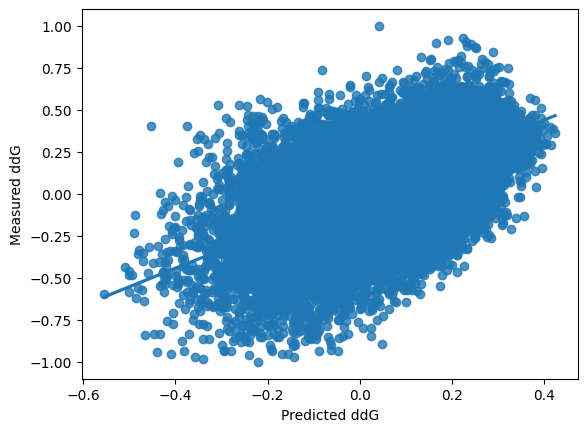

In [16]:
model = lit_model.model

preds =[]
all_y = []

for batch in dataloader_val:
    # read from batch
    x = batch["sequence"][0]
    mask = batch["mask"][0]
    target = batch["labels"][0]
    ## adjust to work with your model
    # predict
    prediction = model.cuda()(x.cuda()).cpu()
    preds.append(prediction[mask==1].flatten().detach().numpy()) # flatten to create one dimensional vector from 2D sequence
    all_y.append(target[mask==1].flatten().detach().numpy()) # flatten to create one dimensional vector from 2D sequence

# concatenate and plot
preds= np.concatenate(preds)
all_y = np.concatenate(all_y)

sns.regplot(x=preds,y=all_y)
plt.xlabel("Predicted ddG")
plt.ylabel("Measured ddG")

# get RMSE, Pearson and Spearman correlation 
print("RMSE:", skmetrics.mean_squared_error(all_y, preds, squared="False"))
print("Pearson r:", scipy.stats.pearsonr(preds, all_y))
print("Spearman r:", scipy.stats.spearmanr(preds, all_y))

RMSE: 0.2551491
Pearson r: PearsonRResult(statistic=0.2540043419956585, pvalue=0.0)
Spearman r: SignificanceResult(statistic=0.21753915857275558, pvalue=0.0)


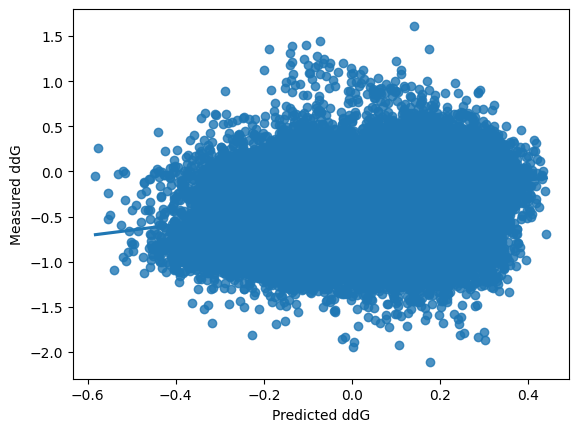

In [20]:
model = lit_model.model

preds =[]
all_y = []

for batch in dataloader_val_dom:
    # read from batch
    x = batch["sequence"][0]
    mask = batch["mask"][0]
    target = batch["labels"][0]
    ## adjust to work with your model
    # predict
    prediction = model.cuda()(x.cuda()).cpu()
    preds.append(prediction[mask==1].flatten().detach().numpy()) # flatten to create one dimensional vector from 2D sequence
    all_y.append(target[mask==1].flatten().detach().numpy()) # flatten to create one dimensional vector from 2D sequence

# concatenate and plot
preds= np.concatenate(preds)
all_y = np.concatenate(all_y)

sns.regplot(x=preds,y=all_y)
plt.xlabel("Predicted ddG")
plt.ylabel("Measured ddG")

# get RMSE, Pearson and Spearman correlation 
print("RMSE:", skmetrics.mean_squared_error(all_y, preds, squared="False"))
print("Pearson r:", scipy.stats.pearsonr(preds, all_y))
print("Spearman r:", scipy.stats.spearmanr(preds, all_y))

RMSE: 0.8908685
Pearson r: PearsonRResult(statistic=0.42236184429230544, pvalue=0.0)
Spearman r: SignificanceResult(statistic=0.3781144123582247, pvalue=0.0)


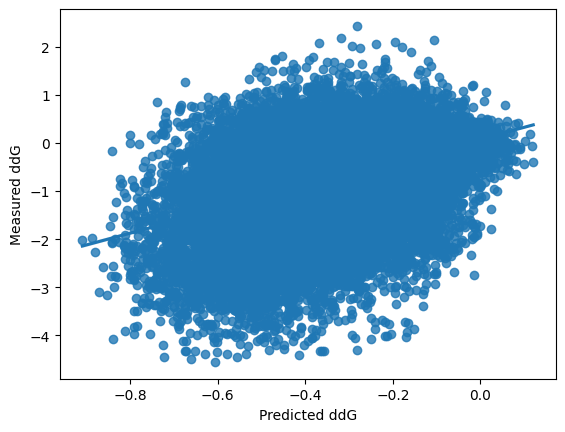

In [46]:
model = lit_model_domainome.model

preds =[]
all_y = []

for batch in dataloader_val:
    # read from batch
    x = batch["sequence"][0]
    mask = batch["mask"][0]
    target = batch["labels"][0]
    ## adjust to work with your model
    # predict
    prediction = model.cuda()(x.cuda()).cpu()
    preds.append(prediction[mask==1].flatten().detach().numpy()) # flatten to create one dimensional vector from 2D sequence
    all_y.append(target[mask==1].flatten().detach().numpy()) # flatten to create one dimensional vector from 2D sequence

# concatenate and plot
preds= np.concatenate(preds)
all_y = np.concatenate(all_y)

sns.regplot(x=preds,y=all_y)
plt.xlabel("Predicted ddG")
plt.ylabel("Measured ddG")

# get RMSE, Pearson and Spearman correlation 
print("RMSE:", skmetrics.mean_squared_error(all_y, preds, squared="False"))
print("Pearson r:", scipy.stats.pearsonr(preds, all_y))
print("Spearman r:", scipy.stats.spearmanr(preds, all_y))

RMSE: 0.88096595
Pearson r: PearsonRResult(statistic=0.5358496101308068, pvalue=0.0)
Spearman r: SignificanceResult(statistic=0.47590765892566506, pvalue=0.0)


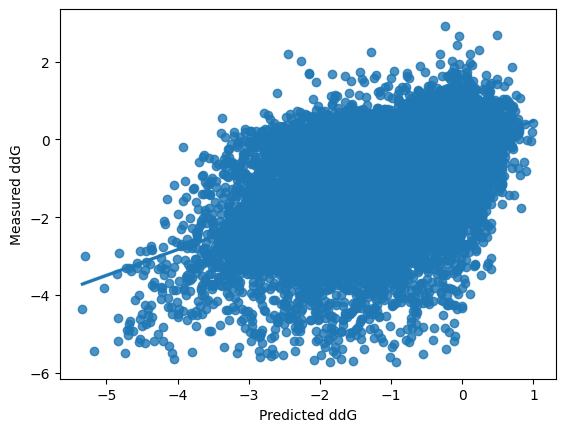

In [16]:
model = lit_model.model

preds =[]
all_y = []

for batch in dataloader_test:
    # read from batch
    x = batch["sequence"][0]
    mask = batch["mask"][0]
    target = batch["labels"][0]
    ## adjust to work with your model
    # predict
    prediction = model.cuda()(x.cuda()).cpu()
    preds.append(prediction[mask==1].flatten().detach().numpy()) # flatten to create one dimensional vector from 2D sequence
    all_y.append(target[mask==1].flatten().detach().numpy()) # flatten to create one dimensional vector from 2D sequence

# concatenate and plot
preds= np.concatenate(preds)
all_y = np.concatenate(all_y)

sns.regplot(x=preds,y=all_y)
plt.xlabel("Predicted ddG")
plt.ylabel("Measured ddG")

# get RMSE, Pearson and Spearman correlation 
print("RMSE:", skmetrics.mean_squared_error(all_y, preds, squared="False"))
print("Pearson r:", scipy.stats.pearsonr(preds, all_y))
print("Spearman r:", scipy.stats.spearmanr(preds, all_y))